In [2]:
import pandas as pd

train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [5]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [6]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [7]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 学習用と検証用に分ける（8:2）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# モデル学習（学習用）
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

# 検証データで予測
val_predictions = model.predict(X_val)

# 精度を確認
acc = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", acc)


Validation Accuracy: 0.7597765363128491


モデルは「どの特徴量が重要だったか」を出力できます。

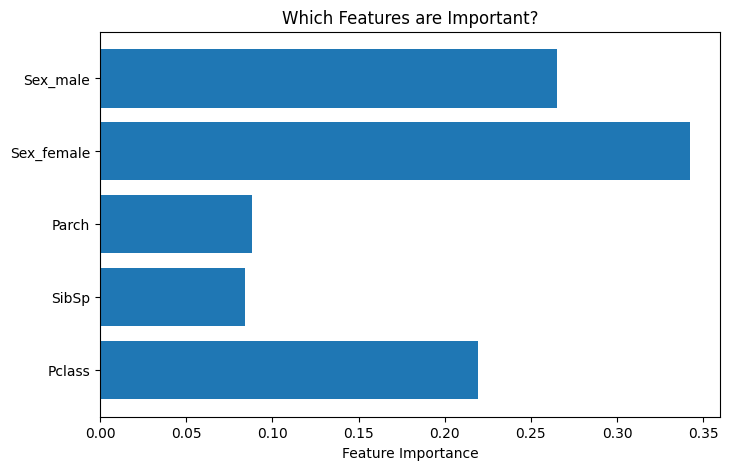

In [9]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
features_list = X.columns

plt.figure(figsize=(8, 5))
plt.barh(features_list, feature_importance)
plt.xlabel("Feature Importance")
plt.title("Which Features are Important?")
plt.show()

もっと予測精度を上げるには「新しい特徴量を作る（特徴量エンジニアリング）」がカギになります。

In [10]:
train_data["Age_bin"] = pd.cut(train_data["Age"], bins=[0, 12, 18, 35, 60, 80], labels=False)
train_data["Fare_bin"] = pd.qcut(train_data["Fare"], 4, labels=False)

test_data["Age_bin"] = pd.cut(test_data["Age"], bins=[0, 12, 18, 35, 60, 80], labels=False)
test_data["Fare_bin"] = pd.qcut(test_data["Fare"], 4, labels=False)

features = ["Pclass", "Sex", "SibSp", "Parch", "Age_bin", "Fare_bin"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

max_depth=5やn_estimators=100をいろいろ変えて、どのパターンが最も精度が良いか試してみましょう。

In [11]:
for depth in [3, 5, 7, 9]:
    model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"max_depth={depth} → Accuracy: {acc:.4f}")

max_depth=3 → Accuracy: 0.7821
max_depth=5 → Accuracy: 0.7598
max_depth=7 → Accuracy: 0.7654
max_depth=9 → Accuracy: 0.7542


クロスバリデーションで安定評価

In [12]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores = cross_val_score(model, X, y, cv=5)

print("Cross-validation scores:", scores)
print("Average CV accuracy:", scores.mean())

Cross-validation scores: [0.82681564 0.82022472 0.83146067 0.79213483 0.85393258]
Average CV accuracy: 0.824913690289373


ランダムフォレストだけでなく、シンプルなロジスティック回帰とも比較するとモデル選定の幅が広がります。

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# モデル構築・学習
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# 評価
val_preds = logreg_model.predict(X_val)
acc = accuracy_score(y_val, val_preds)

print("Logistic Regression Accuracy:", acc)

Logistic Regression Accuracy: 0.7821229050279329


機械学習では「前処理＋モデル構築」を一括で扱える Pipeline を使うのがベストプラクティスです。

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# 数値とカテゴリを分けて処理
num_features = ["SibSp", "Parch", "Age", "Fare"]
cat_features = ["Pclass", "Sex"]

# 前処理設定
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# 全体Pipeline（前処理＋モデル）
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1))
])

# 学習・予測
clf.fit(train_data[num_features + cat_features], y)
predictions = clf.predict(test_data[num_features + cat_features])

Titanicデータでは、以下のように 欠損値処理が重要 になります。

AgeやFareの欠損補完（前処理時に行う）

In [19]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].median())
test_data["Age"] = test_data["Age"].fillna(train_data["Age"].median())
test_data["Fare"] = test_data["Fare"].fillna(train_data["Fare"].median())

欠損が多すぎて削除する選択もOK

In [17]:
train_data.drop("Cabin", axis=1, inplace=True)
test_data.drop("Cabin", axis=1, inplace=True)

Embarked（乗船港）の補完

In [18]:
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])
test_data["Embarked"] = test_data["Embarked"].fillna(train_data["Embarked"].mode()[0])

データの見方を少し変えるだけで、モデルの精度がグンと上がることがあります。よく使われる「隠れた特徴量（新しい列）」をいくつか紹介します👇

1. FamilySize（家族の人数）

In [20]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

 2. IsAlone（一人かどうか）

In [21]:
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

3. Title（名前から敬称を抽出）

In [26]:
# 名前から敬称（Title）を抽出（例: Mr, Miss, Mrsなど）
train_data['Title'] = train_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# レアなタイトルをまとめる
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
               'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Rare')

# 一部の敬称を統一（表記ゆれを解消）
title_mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
train_data['Title'] = train_data['Title'].replace(title_mapping)
test_data['Title'] = test_data['Title'].replace(title_mapping)

複数のモデルを組み合わせてさらに精度を上げましょう。

VotingClassifier（複数モデルの多数決）

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf1 = LogisticRegression(max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
clf3 = SVC(probability=True)

voting_clf = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('svc', clf3)
], voting='soft')

voting_clf.fit(X_train, y_train)
voting_preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, voting_preds)
print("VotingClassifier Accuracy:", acc)


VotingClassifier Accuracy: 0.776536312849162


 SelectKBest（統計的に重要な特徴量を選ぶ）

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# NaN補完（中央値で補完）
imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X)

# 特徴量選択
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X_filled, y)

# 選ばれた特徴量名を表示
selected_features = X.columns[selector.get_support()]
print("Selected features:", list(selected_features))

Selected features: ['Pclass', 'Age_bin', 'Fare_bin', 'Sex_female', 'Sex_male']


In [28]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
